In [9]:
# imports
import keras_tuner as kt
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from nnTrain import getSplitData
from selectionPlots import findAllFilesInPath

In [30]:
def model_builder(hp):
  model = Sequential()

  for i in range(hp.Int("num_layers", 1, 6)): # Variable number of hidden layers
    model.add(Dense(units = hp.Int(f"units_{i}", min_value = 4, max_value = 40, step = 2),
                    activation = hp.Choice("activation", ["relu", "tanh", "elu"]))) # Hidden layer

  if hp.Boolean("dropout"): # Possible dropout layer to prevent overfitting
    model.add(Dropout(rate = hp.Float("dropout_rate", min_value = 0.4, max_value = 0.9, step = 0.1)))

  model.add(Dense(1, activation = "sigmoid")) # Output layer

  learning_rate = hp.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log")

  # Compile the model
  model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate = learning_rate),
                metrics = ["accuracy"])

  return model

In [41]:
sampleNames = findAllFilesInPath("*.root", "nTupleGroups/")
nTupleSamples = dict.fromkeys(sampleNames, 0)
nTupleSamples["nTupleGroups/signalGroup.root"] = 1

# Tuple of variables to get from each file
variables = ["tauPtSum", "zMassSum", "metPt", "deltaRll", "deltaRtt", "deltaRttll", "deltaEtall", "deltaEtatt",
             "nJets", "deltaPhill", "deltaPhitt", "deltaPhilltt", "mmc"]

cut = "3lep"
X_train, X_test, y_train, y_test = getSplitData(nTupleSamples, variables, cut, 0)

In [42]:
# Create the tuner
tuner = kt.Hyperband(model_builder,
                      objective = "val_accuracy",
                      max_epochs = 30,
                      factor = 3,
                      directory = "hyperTuning",
                      project_name = "hyperTuning" + cut,
                      overwrite = True)

stop_early = EarlyStopping(monitor = "val_loss", patience = 5)

In [43]:
# 0.25*0.8 = 0.2 to get 20% of the data for validation
tuner.search(X_train, y_train, epochs = 10, validation_split = 0.25, callbacks = [stop_early])

Trial 90 Complete [00h 00m 24s]
val_accuracy: 0.8293099999427795

Best val_accuracy So Far: 0.8363597393035889
Total elapsed time: 00h 07m 53s
INFO:tensorflow:Oracle triggered exit


In [45]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(best_hps.values)

print("The hyperparameter search is complete (" + cut + "). The optimal number of layers was:", best_hps.get("num_layers"))

for i in range(best_hps.get("num_layers") + 1):
  print("layer", i, ":", best_hps.get(f"units_{i}"), best_hps.get("activation"))

print("Learning rate:", best_hps.get("lr"))

print("Dropout:", best_hps.get("dropout"))
if best_hps.get("dropout"):
  print("Dropout rate:", best_hps.get("dropout_rate"))

{'num_layers': 3, 'units_0': 30, 'activation': 'relu', 'dropout': False, 'lr': 0.0008878294112491289, 'units_1': 32, 'dropout_rate': 0.8, 'units_2': 8, 'units_3': 6, 'units_4': 18, 'units_5': 24, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}
The hyperparameter search is complete. The optimal number of layers was: 3
layer 0 : 30 relu
layer 1 : 32 relu
layer 2 : 8 relu
layer 3 : 6 relu
Learning rate: 0.0008878294112491289
Dropout: False


In [46]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 50, validation_split = 0.25)

# Find the best number of epochs to train for
valAccPerEpoch = history.history["val_accuracy"]
bestEpoch = valAccPerEpoch.index(max(valAccPerEpoch)) + 1
print("Best epoch:", bestEpoch)

Epoch 1/50
439/439 [==============================] - 1s 2ms/step - loss: 0.4814 - accuracy: 0.7728 - val_loss: 0.4321 - val_accuracy: 0.8176
Epoch 2/50
439/439 [==============================] - 1s 2ms/step - loss: 0.4160 - accuracy: 0.8176 - val_loss: 0.4111 - val_accuracy: 0.8297
Epoch 3/50
439/439 [==============================] - 1s 2ms/step - loss: 0.3997 - accuracy: 0.8248 - val_loss: 0.4048 - val_accuracy: 0.8306
Epoch 4/50
439/439 [==============================] - 1s 2ms/step - loss: 0.3937 - accuracy: 0.8298 - val_loss: 0.4019 - val_accuracy: 0.8285
Epoch 5/50
439/439 [==============================] - 1s 2ms/step - loss: 0.3898 - accuracy: 0.8301 - val_loss: 0.3994 - val_accuracy: 0.8312
Epoch 6/50
439/439 [==============================] - 1s 2ms/step - loss: 0.3863 - accuracy: 0.8311 - val_loss: 0.3957 - val_accuracy: 0.8325
Epoch 7/50
439/439 [==============================] - 1s 2ms/step - loss: 0.3823 - accuracy: 0.8318 - val_loss: 0.3943 - val_accuracy: 0.8332
Epoch 

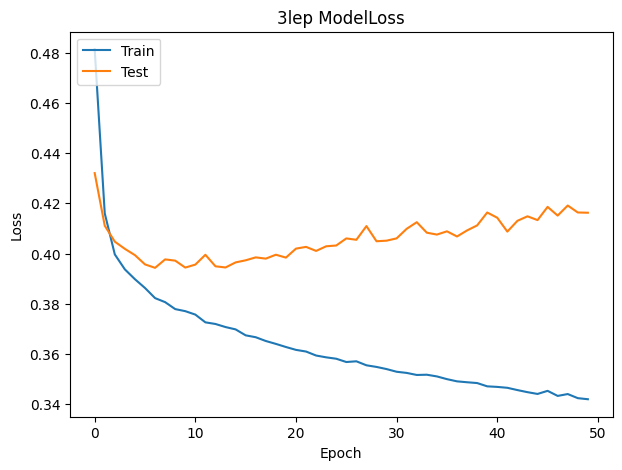

<Figure size 640x480 with 0 Axes>

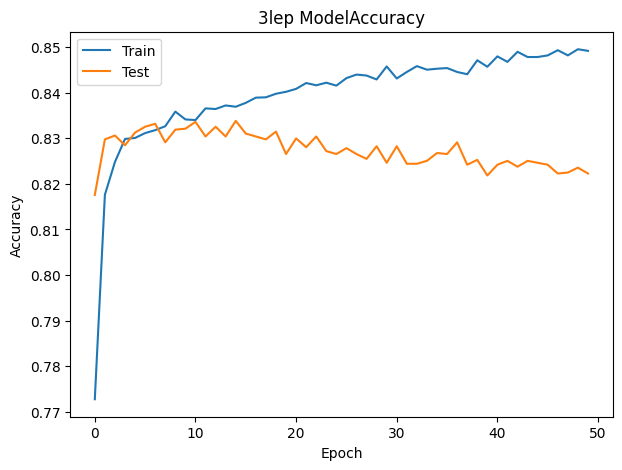

<Figure size 640x480 with 0 Axes>

In [47]:
# Plot the accuracy and loss per epoch
%matplotlib inline
import matplotlib.pyplot as plt
for i in ("loss", "accuracy"):
    plt.figure(figsize = (7, 5))
    plt.plot(history.history[i])
    plt.plot(history.history["val_" + i])
    plt.title(cut + " Model" + i.capitalize())
    plt.ylabel(i.capitalize())
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()
    plt.clf()

In [48]:
# Train the model with the optimal number of epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = bestEpoch, validation_split = 0.25)

Epoch 1/15
439/439 [==============================] - 1s 2ms/step - loss: 0.4881 - accuracy: 0.7746 - val_loss: 0.4317 - val_accuracy: 0.8122
Epoch 2/15
439/439 [==============================] - 1s 2ms/step - loss: 0.4170 - accuracy: 0.8185 - val_loss: 0.4157 - val_accuracy: 0.8225
Epoch 3/15
439/439 [==============================] - 1s 2ms/step - loss: 0.4009 - accuracy: 0.8248 - val_loss: 0.4029 - val_accuracy: 0.8295
Epoch 4/15
439/439 [==============================] - 1s 2ms/step - loss: 0.3935 - accuracy: 0.8294 - val_loss: 0.4010 - val_accuracy: 0.8285
Epoch 5/15
439/439 [==============================] - 1s 2ms/step - loss: 0.3896 - accuracy: 0.8319 - val_loss: 0.3986 - val_accuracy: 0.8302
Epoch 6/15
439/439 [==============================] - 1s 2ms/step - loss: 0.3858 - accuracy: 0.8350 - val_loss: 0.4032 - val_accuracy: 0.8248
Epoch 7/15
439/439 [==============================] - 1s 2ms/step - loss: 0.3827 - accuracy: 0.8350 - val_loss: 0.3981 - val_accuracy: 0.8280
Epoch 

In [40]:
# Save the model
model.save("nnModels/hyperTuned" + cut + ".h5")